In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import json
import numpy 
import os
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline  
import pyarrow
import sys

from datetime import date
from dotenv import load_dotenv
from sqlalchemy import create_engine
from os import path
from typing import List,Dict, Tuple
from collections import defaultdict
pd.set_option("display.max_columns", None)

load_dotenv(verbose=True)
BIGQUERY_CREDENTIALS_PATH = os.environ.get('BIGQUERY_CREDENTIALS_PATH')
engine = create_engine('bigquery://bespoke-financial/ProdMetrcData', credentials_path=os.path.expanduser(BIGQUERY_CREDENTIALS_PATH))

sys.path.append(path.realpath(path.join(os.getcwd(), "../core")))
sys.path.append(path.realpath(path.join(os.getcwd(), "../../src")))
sys.path.append(path.realpath(path.join(os.getcwd(), "../../scripts")))

import create_queries
import prepare_data

from bespoke.inventory.analysis.shared import download_util, inventory_types
from bespoke.inventory.analysis import active_inventory_util as util
from bespoke.inventory.analysis import inventory_valuations_util as valuations_util

%load_ext autoreload
%autoreload 2

In [43]:
from underwriting import client_surveillance_jupyter

In [4]:
COMPANY_IDENTIFIER = ['EMA','EMM','EMT','EMF']
TRANSFER_PACKAGES_START_DATE = '2020-01-01'
SALES_TRANSACTIONS_START_DATE = '2020-01-01'

In [5]:
#fetch download report and lisences
company_licenses_query = create_queries.create_company_licenses_query(COMPANY_IDENTIFIER)
company_download_summaries_query = create_queries.create_company_download_summaries_query(COMPANY_IDENTIFIER, TRANSFER_PACKAGES_START_DATE)

company_licenses_dataframe = pd.read_sql_query(company_licenses_query, engine)
company_download_summaries_dataframe = pd.read_sql_query(company_download_summaries_query, engine)

In [6]:
company_licenses_dataframe

,us_state,license_number,license_category,legal_name,is_current,license_status,rollup_id,license_description,company_id,facility_row_id
0,CA,C10-0000695-LIC,Retailer,EMBARC TAHOE LLC,True,Active,CA-04530,Retailer,465b4790-33c5-4228-adf3-5ee9f4edf62e,350aeac8-1a9b-4c7e-b62d-a439bcc4b7fb
1,CA,C10-0000774-LIC,Retailer,alameda patients group llc,True,Active,CA-05437,Retailer,bc8d06ac-e6a4-406a-afb7-c4c0d8481522,8e104bcf-e0f2-46bb-ac63-14482463074f
2,CA,C10-0000786-LIC,Retailer,Embarc Martinez LLC,True,Active,CA-04530,Retailer,e4947919-767e-4a36-828f-ec8c03469591,db4badd6-18b6-4cff-b4d6-62c4b5f4bf16
3,CA,C10-0000939-LIC,Retailer,Responsible And Compliant Retail Fairfield LLC,True,Active,CA-04530,Retailer,4633ceb1-7b64-48d1-93db-4b030bfb7c6a,4ee65532-edaa-412f-ae6e-e63a2682f9db


## Check download status summaries

In [7]:
license_numbers = company_download_summaries_dataframe['license_number'].unique()
download_summary_records = company_download_summaries_dataframe.to_dict('records')

In [8]:
license_numbers

array(['C10-0000695-LIC', 'C10-0000774-LIC', 'C10-0000786-LIC',
       'C10-0000939-LIC'], dtype=object)

In [9]:
bad_download_history = client_surveillance_jupyter.check_company_license_download(license_numbers,download_summary_records)

Verifying download summaries for license C10-0000695-LIC...
Earliest download summary: 2021-10-12
Latest download summary: 2022-05-05

Verifying download summaries for license C10-0000774-LIC...
Earliest download summary: 2021-10-12
Latest download summary: 2022-05-05

Verifying download summaries for license C10-0000786-LIC...
Earliest download summary: 2021-10-12
Latest download summary: 2022-05-05
Found bad download summary for license C10-0000786-LIC on date 2022-03-11
Found bad download summary for license C10-0000786-LIC on date 2022-03-10
Found bad download summary for license C10-0000786-LIC on date 2022-03-09

Verifying download summaries for license C10-0000939-LIC...
Earliest download summary: 2021-10-01
Latest download summary: 2022-05-05

[FAILURE] Found a total of 3 bad download summaries


In [10]:
bad_download_history

defaultdict(list,
            {'C10-0000786-LIC': [datetime.date(2022, 3, 11),
              datetime.date(2022, 3, 10),
              datetime.date(2022, 3, 9)]})

## Choose license numbers

In [11]:
# get list of retailer license numbers
license_numbers = list(company_licenses_dataframe[company_licenses_dataframe['license_category'].isin(['Retailer', 'Multiple'])]['license_number'].unique())
license_numbers

['C10-0000695-LIC', 'C10-0000774-LIC', 'C10-0000786-LIC', 'C10-0000939-LIC']

# License check

In [12]:
company_licenses_dataframe

,us_state,license_number,license_category,legal_name,is_current,license_status,rollup_id,license_description,company_id,facility_row_id
0,CA,C10-0000695-LIC,Retailer,EMBARC TAHOE LLC,True,Active,CA-04530,Retailer,465b4790-33c5-4228-adf3-5ee9f4edf62e,350aeac8-1a9b-4c7e-b62d-a439bcc4b7fb
1,CA,C10-0000774-LIC,Retailer,alameda patients group llc,True,Active,CA-05437,Retailer,bc8d06ac-e6a4-406a-afb7-c4c0d8481522,8e104bcf-e0f2-46bb-ac63-14482463074f
2,CA,C10-0000786-LIC,Retailer,Embarc Martinez LLC,True,Active,CA-04530,Retailer,e4947919-767e-4a36-828f-ec8c03469591,db4badd6-18b6-4cff-b4d6-62c4b5f4bf16
3,CA,C10-0000939-LIC,Retailer,Responsible And Compliant Retail Fairfield LLC,True,Active,CA-04530,Retailer,4633ceb1-7b64-48d1-93db-4b030bfb7c6a,4ee65532-edaa-412f-ae6e-e63a2682f9db


In [13]:
company_state = list(company_licenses_dataframe['us_state'].unique())[0]
company_state

'CA'

In [14]:
retial_license_check_df = company_licenses_dataframe[company_licenses_dataframe['license_number'].isin(license_numbers)][['license_number','license_category','is_current','license_status','us_state']].reset_index(drop = True)
retial_license_check_df['license_check'] = ['YES' if retial_license_check_df['license_status'][i] == 'Active' or str(retial_license_check_df['is_current'][i]) == 'True' else 'NO' for i in range(len(retial_license_check_df))]


In [15]:
retial_license_check_df

,license_number,license_category,is_current,license_status,us_state,license_check
0,C10-0000695-LIC,Retailer,True,Active,CA,YES
1,C10-0000774-LIC,Retailer,True,Active,CA,YES
2,C10-0000786-LIC,Retailer,True,Active,CA,YES
3,C10-0000939-LIC,Retailer,True,Active,CA,YES


## Pull data

In [16]:
company_incoming_transfer_packages_query = create_queries.create_company_incoming_transfer_packages_query(
    COMPANY_IDENTIFIER,
    TRANSFER_PACKAGES_START_DATE,
    license_numbers=license_numbers,
)
company_outgoing_transfer_packages_query = create_queries.create_company_outgoing_transfer_packages_query(
    COMPANY_IDENTIFIER,
    TRANSFER_PACKAGES_START_DATE,
    license_numbers=license_numbers,
)
company_unknown_transfer_packages_query = create_queries.create_company_unknown_transfer_packages_query(
    COMPANY_IDENTIFIER,
    TRANSFER_PACKAGES_START_DATE,
#     license_numbers=license_numbers,
)
company_sales_transactions_query = create_queries.create_company_sales_transactions_query(
    COMPANY_IDENTIFIER,
    SALES_TRANSACTIONS_START_DATE,
    license_numbers=license_numbers,
)
company_sales_receipts_query = create_queries.create_company_sales_receipts_query(
    COMPANY_IDENTIFIER,
    SALES_TRANSACTIONS_START_DATE,
    license_numbers=license_numbers,
)
company_sales_receipts_with_transactions_query = create_queries.create_company_sales_receipts_with_transactions_query(
    COMPANY_IDENTIFIER,
    SALES_TRANSACTIONS_START_DATE,
    license_numbers=license_numbers,
)
company_inventory_packages_query = create_queries.create_company_inventory_packages_query(
    COMPANY_IDENTIFIER,
    include_quantity_zero=True,
    license_numbers=license_numbers,
)

company_incoming_transfer_packages_dataframe = pd.read_sql_query(company_incoming_transfer_packages_query, engine)
company_outgoing_transfer_packages_dataframe = pd.read_sql_query(company_outgoing_transfer_packages_query, engine)
company_unknown_transfer_packages_dataframe = pd.read_sql_query(company_unknown_transfer_packages_query, engine)
company_sales_transactions_dataframe = pd.read_sql_query(company_sales_transactions_query, engine)
company_sales_receipts_dataframe = pd.read_sql_query(company_sales_receipts_query, engine)
company_sales_receipts_with_transactions_dataframe = pd.read_sql_query(company_sales_receipts_with_transactions_query, engine)
company_inventory_packages_dataframe = pd.read_sql_query(company_inventory_packages_query, engine)

In [17]:
#make sure we did pulled all location's data
company_incoming_transfer_packages_dataframe['license_number'].unique()

array(['C10-0000774-LIC', 'C10-0000695-LIC', 'C10-0000786-LIC',
       'C10-0000939-LIC'], dtype=object)

In [18]:
company_sales_receipts_with_transactions_dataframe['license_number'].unique()

array(['C10-0000939-LIC', 'C10-0000774-LIC', 'C10-0000695-LIC',
       'C10-0000786-LIC'], dtype=object)

In [19]:
company_inventory_packages_dataframe['license_number'].unique()

array(['C10-0000774-LIC', 'C10-0000786-LIC', 'C10-0000695-LIC',
       'C10-0000939-LIC'], dtype=object)

## Unknown transfer packages

In [20]:
unknown_package_count = client_surveillance_jupyter.check_unknown_transfer_packages(company_unknown_transfer_packages_dataframe)
unknown_package_count

[FAILURE] Found a total of 42 unknown transfer packages


42

## Receiver wholesale price coverage

In [21]:
company_incoming_transfer_packages_dataframe[company_incoming_transfer_packages_dataframe['receiver_wholesale_price'].notnull()].shape

(25021, 32)

In [22]:
company_incoming_transfer_packages_dataframe.shape

(25922, 32)

In [23]:
rwp_coverage = client_surveillance_jupyter.check_receiver_wholesale_price_coverage(company_incoming_transfer_packages_dataframe)


97.0% of incoming transfer packages have receiver wholesale price


## dedupe sales transactions

In [24]:
deduped_sales_receipts_with_transactions_dataframe = prepare_data.dedupe_sales_transactions(company_sales_receipts_with_transactions_dataframe)

In [25]:
deduped_sales_receipts_with_transactions_dataframe['sales_month'] = deduped_sales_receipts_with_transactions_dataframe['sales_datetime'].dt.strftime('%Y-%m')

In [26]:
#check we have all locations
deduped_sales_receipts_with_transactions_dataframe['license_number'].unique()

array(['C10-0000939-LIC', 'C10-0000774-LIC', 'C10-0000695-LIC',
       'C10-0000786-LIC'], dtype=object)

## Trxns missing incoming transfer packages

In [27]:
incoming_transfer_package_coverage,incoming_transfer_package_coverage_missing = client_surveillance_jupyter.check_incoming_transfer_package_coverage(company_incoming_transfer_packages_dataframe,deduped_sales_receipts_with_transactions_dataframe)

# transactions missing incoming transfer package: 908 (0.16630006172149867%)
# transactions total: 546001


In [28]:
month_to_missing_count = incoming_transfer_package_coverage_missing[['sales_month','receipt_number']].groupby(['sales_month']).apply(lambda x: len(x['receipt_number'].unique()))
month_to_missing_count


sales_month
2022-04    610
2022-05    158
dtype: int64

## Receipts missing metrc_sales_transactions

In [29]:
sales_receipt_with_transactions_records = deduped_sales_receipts_with_transactions_dataframe.to_dict('records')

receipt_number_to_transactions = {}
for sales_receipt_with_transaction_record in sales_receipt_with_transactions_records:
    receipt_number = sales_receipt_with_transaction_record['receipt_number']
    if receipt_number in receipt_number_to_transactions:
        receipt_number_to_transactions[receipt_number] += [sales_receipt_with_transaction_record]
    else:
        receipt_number_to_transactions[receipt_number] = [sales_receipt_with_transaction_record]

In [30]:
import math

def float_eq(receipt_total_price: float, transactions_total_price: float, num_transactions: int) -> bool:
    # For every additional transaction, increase threshold by 0.01 (a penny).
    threshold = num_transactions * 0.01
    return math.isclose(receipt_total_price, transactions_total_price, abs_tol=threshold)

mismatch_count = 0 # Count of receipts where receipt total price does not match transactions total price.
missing_count = 0 # Count of receipts with no transactions.
total_count = 0 # Count of receipts (including those missing transactions).

mismatch_over_count = 0
mismatch_under_count = 0

month_to_mismatch_count = {}
month_to_missing_count = {}

month_to_mismatch_over_count = {}
month_to_mismatch_under_count = {}

example_mismatch_over_receipts = []
example_mismatch_under_receipts = []

for receipt_number, receipt_transactions in list(receipt_number_to_transactions.items()):
    receipt_total_price = receipt_transactions[0]['rt_total_price']
    receipt_sales_month = receipt_transactions[0]['sales_month']
    receipt_total_packages = receipt_transactions[0]['total_packages']

    total_count += 1

    if len(receipt_transactions) == 1 and receipt_transactions[0]['tx_package_id'] == None:
        missing_count += 1
        if receipt_sales_month not in month_to_missing_count:
            month_to_missing_count[receipt_sales_month] = 0
        month_to_missing_count[receipt_sales_month] += 1
        continue

    # Check whether 'total_packages' field of sales receipt matches number of transactions related to receipt.
    if receipt_total_packages != len(receipt_transactions):
        missing_count += 1
        if receipt_sales_month not in month_to_missing_count:
            month_to_missing_count[receipt_sales_month] = 0
        month_to_missing_count[receipt_sales_month] += 1
        continue

    transactions_total_price = sum(receipt_transaction['tx_total_price'] for receipt_transaction in receipt_transactions)
    if not float_eq(receipt_total_price, transactions_total_price, len(receipt_transactions)):
        mismatch_count += 1
        if receipt_total_price < transactions_total_price:
            mismatch_over_count += 1
            example_mismatch_over_receipts += [(receipt_number, receipt_transactions)]
        else:
            mismatch_under_count += 1
            example_mismatch_under_receipts += [(receipt_number, receipt_transactions)]

        if receipt_sales_month not in month_to_mismatch_count:
            month_to_mismatch_count[receipt_sales_month] = 0
        month_to_mismatch_count[receipt_sales_month] += 1
        continue

print(f'# receipts with mismatching transactions: {mismatch_count} ({mismatch_count / total_count * 100}%)')
print(f'# receipts missing transactions: {missing_count} ({missing_count / total_count * 100}%)')
print(f'# receipts total: {total_count}')

if mismatch_count:
    print(f'# mismatch receipt vs transactions (transactions over): {mismatch_over_count} ({mismatch_over_count / mismatch_count * 100}%)')
    print(f'# mismatch receipt vs transactions (transactions under): {mismatch_under_count} ({mismatch_under_count / mismatch_count * 100}%)')

# receipts with mismatching transactions: 0 (0.0%)
# receipts missing transactions: 5 (0.0019686589495235846%)
# receipts total: 253980


In [31]:
company_sales_receipts_dataframe['sales_month'] = company_sales_receipts_dataframe['sales_datetime'].dt.strftime('%Y-%m')

<AxesSubplot:xlabel='sales_month'>

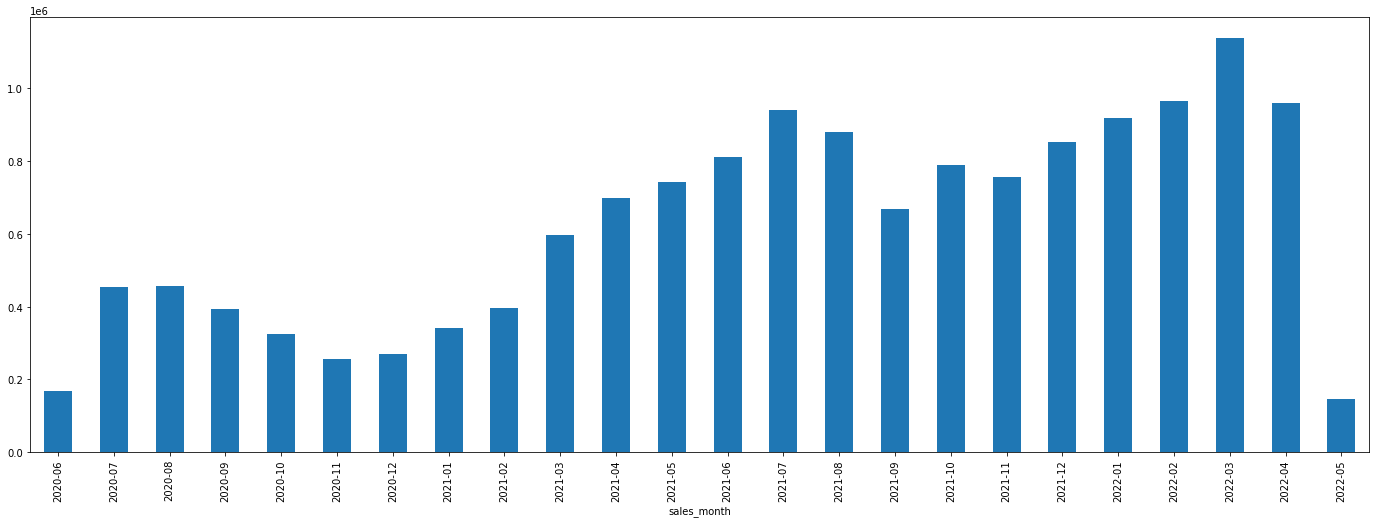

In [32]:
deduped_sales_receipts_with_transactions_dataframe.groupby(['sales_month'])['tx_total_price'].sum().plot.bar(figsize=(24, 8), stacked=True)

In [33]:
if COMPANY_IDENTIFIER == ['EMA','EMM','EMT','EMF']:
    #incoming transfer
    company_incoming_transfer_packages_dataframe_ema = company_incoming_transfer_packages_dataframe[company_incoming_transfer_packages_dataframe['license_number'] == 'C10-0000774-LIC']
    company_incoming_transfer_packages_dataframe_emm = company_incoming_transfer_packages_dataframe[company_incoming_transfer_packages_dataframe['license_number'] == 'C10-0000786-LIC']
    company_incoming_transfer_packages_dataframe_emt = company_incoming_transfer_packages_dataframe[company_incoming_transfer_packages_dataframe['license_number'] == 'C10-0000695-LIC']
    company_incoming_transfer_packages_dataframe_emf = company_incoming_transfer_packages_dataframe[company_incoming_transfer_packages_dataframe['license_number'] == 'C10-0000939-LIC']
    #sales & receipt
    deduped_sales_receipts_with_transactions_dataframe_ema = deduped_sales_receipts_with_transactions_dataframe[deduped_sales_receipts_with_transactions_dataframe['license_number'] == 'C10-0000774-LIC']
    deduped_sales_receipts_with_transactions_dataframe_emm = deduped_sales_receipts_with_transactions_dataframe[deduped_sales_receipts_with_transactions_dataframe['license_number'] == 'C10-0000786-LIC']
    deduped_sales_receipts_with_transactions_dataframe_emt = deduped_sales_receipts_with_transactions_dataframe[deduped_sales_receipts_with_transactions_dataframe['license_number'] == 'C10-0000695-LIC']
    deduped_sales_receipts_with_transactions_dataframe_emf = deduped_sales_receipts_with_transactions_dataframe[deduped_sales_receipts_with_transactions_dataframe['license_number'] == 'C10-0000939-LIC']
    #inventory
    company_inventory_packages_dataframe_ema = company_inventory_packages_dataframe[company_inventory_packages_dataframe['license_number'] == 'C10-0000774-LIC']
    company_inventory_packages_dataframe_emm = company_inventory_packages_dataframe[company_inventory_packages_dataframe['license_number'] == 'C10-0000786-LIC']
    company_inventory_packages_dataframe_emt = company_inventory_packages_dataframe[company_inventory_packages_dataframe['license_number'] == 'C10-0000695-LIC']
    company_inventory_packages_dataframe_emf = company_inventory_packages_dataframe[company_inventory_packages_dataframe['license_number'] == 'C10-0000939-LIC']
    

# Vendor churn

In [34]:
VC_START_DATE = '2020-01-01'
VC_END_DATE = '2022-04-01'
VC_MONTH_LIST = ['2022-01-01','2022-02-01','2022-03-01','2022-04-01']
VC_MONTH_END = VC_MONTH_LIST[-1]

In [44]:
churn_ema,vc_matrix_ema = client_surveillance_jupyter.calculate_vendor_churn(company_incoming_transfer_packages_dataframe_ema,['C10-0000774-LIC'],VC_START_DATE,VC_END_DATE,VC_MONTH_LIST)
churn_emm,vc_matrix_emm = client_surveillance_jupyter.calculate_vendor_churn(company_incoming_transfer_packages_dataframe_emm,['C10-0000786-LIC'],VC_START_DATE,VC_END_DATE,VC_MONTH_LIST)
churn_emt,vc_matrix_emt = client_surveillance_jupyter.calculate_vendor_churn(company_incoming_transfer_packages_dataframe_emt,['C10-0000695-LIC'],VC_START_DATE,VC_END_DATE,VC_MONTH_LIST)
churn_emf,vc_matrix_emf = client_surveillance_jupyter.calculate_vendor_churn(company_incoming_transfer_packages_dataframe_emf,['C10-0000939-LIC'],VC_START_DATE,VC_END_DATE,VC_MONTH_LIST)



In [36]:
churn_ema_short,vc_matrix_ema_short = client_surveillance_jupyter.calculate_vendor_churn_short(company_incoming_transfer_packages_dataframe_ema,['C10-0000774-LIC'],VC_START_DATE,VC_END_DATE,VC_MONTH_LIST,VC_MONTH_END)
churn_emm_short,vc_matrix_emm_short = client_surveillance_jupyter.calculate_vendor_churn_short(company_incoming_transfer_packages_dataframe_emm,['C10-0000786-LIC'],VC_START_DATE,VC_END_DATE,VC_MONTH_LIST,VC_MONTH_END)
churn_emt_short,vc_matrix_emt_short = client_surveillance_jupyter.calculate_vendor_churn_short(company_incoming_transfer_packages_dataframe_emt,['C10-0000695-LIC'],VC_START_DATE,VC_END_DATE,VC_MONTH_LIST,VC_MONTH_END)
churn_emf_short,vc_matrix_emf_short = client_surveillance_jupyter.calculate_vendor_churn_short(company_incoming_transfer_packages_dataframe_emf,['C10-0000939-LIC'],VC_START_DATE,VC_END_DATE,VC_MONTH_LIST,VC_MONTH_END)



In [45]:
#sanity check
churn_ema

,year_month,%_inactive
year_month,,
2020-01-01,2020-01-01,0.000000
2020-02-01,2020-02-01,0.000000
2020-03-01,2020-03-01,0.000000
2020-04-01,2020-04-01,0.000000
2020-05-01,2020-05-01,0.000000
2020-06-01,2020-06-01,0.000000
2020-07-01,2020-07-01,0.000000
2020-08-01,2020-08-01,0.000000
2020-09-01,2020-09-01,0.000000


In [46]:
vc_matrix_ema[vc_matrix_ema['measure'] == 'Inactive']['perc_total'].sum()

0.17867599641964615

In [47]:
churn_ema_short

,year_month,%_inactive
year_month,,
2020-01-01,2020-01-01,0.000000
2020-02-01,2020-02-01,0.000000
2020-03-01,2020-03-01,0.000000
2020-04-01,2020-04-01,0.000000
2020-05-01,2020-05-01,0.000000
2020-06-01,2020-06-01,0.000000
2020-07-01,2020-07-01,0.000000
2020-08-01,2020-08-01,0.000000
2020-09-01,2020-09-01,0.000000


In [48]:
vc_matrix_ema_short[vc_matrix_ema_short['measure'] == 'Inactive']['perc_total'].sum()

0.13716812270860396

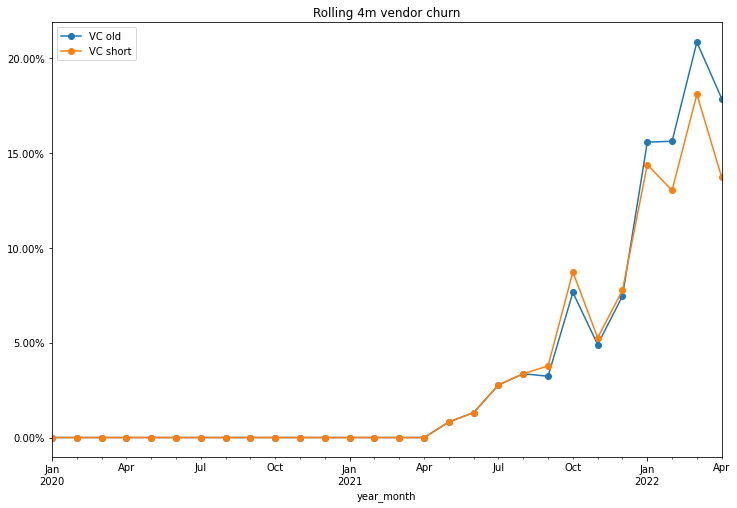

In [41]:
ax = churn_ema['%_inactive'].plot(marker = 'o',figsize = (12,8),label = 'VC old')
ax = churn_ema_short['%_inactive'].plot(marker = 'o',figsize = (12,8),label = 'VC short')
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.2%}'.format(x) for x in vals])
ax = plt.title('Rolling 4m vendor churn')
ax = plt.legend()

# Receiver wholesale price outlier check

In [ ]:
per_unit_incoming_package_sort,per_unit_incoming_product_sort = client_surveillance_jupyter.check_per_unit_incoming(company_incoming_transfer_packages_dataframe)


In [ ]:
# top 5
print('Top 5 per unit incoming packages')
per_unit_incoming_package_sort.head(20)

In [ ]:
print('Bottom 5 per unit incoming packages')
per_unit_incoming_package_sort.dropna().tail(5)


In [ ]:
# look at large cost items if any
company_incoming_transfer_packages_dataframe[company_incoming_transfer_packages_dataframe['per_unit_incoming'] > 10000]

# COGS analysis

In [ ]:
df_in = company_incoming_transfer_packages_dataframe[company_incoming_transfer_packages_dataframe['per_unit_incoming'] <= 10000]
df_inventory = company_inventory_packages_dataframe
df_sales = deduped_sales_receipts_with_transactions_dataframe

### ema

In [ ]:
df_inventory_ema = company_inventory_packages_dataframe_ema
df_sales_ema = deduped_sales_receipts_with_transactions_dataframe_ema

In [ ]:
df_summary_simp_ema,_ = client_surveillance_jupyter.cogs_analysis(df_in,df_sales_ema,'monthly',company_state)



In [ ]:
df_summary_simp_ema

In [ ]:
ema_revenue_vs_state = client_surveillance_jupyter.get_gmv_change(company_state,df_summary_simp_ema)
ema_revenue_vs_state


In [ ]:
round(ema_revenue_vs_state.dropna()['total'].sum(),2)

### emm

In [ ]:
df_inventory_emm = company_inventory_packages_dataframe_emm
df_sales_emm = deduped_sales_receipts_with_transactions_dataframe_emm

In [ ]:
df_summary_simp_emm,_ = client_surveillance_jupyter.cogs_analysis(df_in,df_sales_emm,'monthly',company_state)


In [ ]:
df_summary_simp_emm

In [ ]:
emm_revenue_vs_state = client_surveillance_jupyter.get_gmv_change(company_state,df_summary_simp_emm)
emm_revenue_vs_state

In [ ]:
round(emm_revenue_vs_state.dropna()['total'].sum(),2)

### emt

In [ ]:
df_inventory_emt = company_inventory_packages_dataframe_emt
df_sales_emt = deduped_sales_receipts_with_transactions_dataframe_emt

In [ ]:
df_summary_simp_emt,_ = client_surveillance_jupyter.cogs_analysis(df_in,df_sales_emt,'monthly',company_state)


In [ ]:
df_summary_simp_emt

In [ ]:
emt_revenue_vs_state = client_surveillance_jupyter.get_gmv_change(company_state,df_summary_simp_emt)
emt_revenue_vs_state

In [ ]:
round(emt_revenue_vs_state.dropna()['total'].sum(),2)

### emf

In [ ]:
df_inventory_emf = company_inventory_packages_dataframe_emf
df_sales_emf = deduped_sales_receipts_with_transactions_dataframe_emf

In [ ]:
df_summary_simp_emf,_ = client_surveillance_jupyter.cogs_analysis(df_in,df_sales_emf,'monthly',company_state)


In [ ]:
df_summary_simp_emf

In [ ]:
emf_revenue_vs_state = client_surveillance_jupyter.get_gmv_change(company_state,df_summary_simp_emf)
emf_revenue_vs_state

In [ ]:
round(emf_revenue_vs_state.dropna()['total'].sum(),2)

# Inventory

In [ ]:
today = date.today()
today

In [ ]:
COMPANY_IDENTIFIER

In [ ]:
license_numbers

In [ ]:
df_inventory_license_ema_msrp = client_surveillance_jupyter.calculate_msrp_based_inventory_valuation(df_in,df_sales_ema,df_inventory_ema,['C10-0000774-LIC'],today)
df_inventory_license_emm_msrp = client_surveillance_jupyter.calculate_msrp_based_inventory_valuation(df_in,df_sales_emm,df_inventory_emm,['C10-0000786-LIC'],today)
df_inventory_license_emt_msrp = client_surveillance_jupyter.calculate_msrp_based_inventory_valuation(df_in,df_sales_emt,df_inventory_emt,['C10-0000695-LIC'],today)
df_inventory_license_emf_msrp = client_surveillance_jupyter.calculate_msrp_based_inventory_valuation(df_in,df_sales_emf,df_inventory_emf,['C10-0000939-LIC'],today)

In [ ]:
df_inventory_license_ema_msrp

In [ ]:
df_inventory_license_ema = client_surveillance_jupyter.calculate_inventory_valuation(df_in,df_inventory_ema,['C10-0000774-LIC'],today)
df_inventory_license_emm = client_surveillance_jupyter.calculate_inventory_valuation(df_in,df_inventory_emm,['C10-0000786-LIC'],today)
df_inventory_license_emt = client_surveillance_jupyter.calculate_inventory_valuation(df_in,df_inventory_emt,['C10-0000695-LIC'],today)
df_inventory_license_emf = client_surveillance_jupyter.calculate_inventory_valuation(df_in,df_inventory_emf,['C10-0000939-LIC'],today)

In [ ]:
df_inventory_license_ema

# Create Template

In [ ]:
current_month = '2022-04'

In [ ]:
template_ema = client_surveillance_jupyter.create_template_new(ema_revenue_vs_state,df_summary_simp_ema,\
                                                               df_inventory_license_ema,\
                                                               df_inventory_license_ema_msrp,churn_ema_short,\
                                                               retial_license_check_df,['C10-0000774-LIC'],\
                                                               company_state,current_month)

In [ ]:
template_ema

In [ ]:
template_emm = client_surveillance_jupyter.create_template_new(emm_revenue_vs_state,df_summary_simp_emm,\
                                                               df_inventory_license_emm,\
                                                               df_inventory_license_emm_msrp,churn_emm_short,\
                                                               retial_license_check_df,['C10-0000786-LIC'],\
                                                               company_state,current_month)

In [ ]:
template_emm

In [ ]:
template_emt = client_surveillance_jupyter.create_template_new(emt_revenue_vs_state,df_summary_simp_emt,\
                                                               df_inventory_license_emt,\
                                                               df_inventory_license_emt_msrp,churn_emt_short,\
                                                               retial_license_check_df,['C10-0000695-LIC'],\
                                                               company_state,current_month)

In [ ]:
template_emt

In [ ]:
template_emf = client_surveillance_jupyter.create_template_new(emf_revenue_vs_state,df_summary_simp_emf,\
                                                               df_inventory_license_emf,\
                                                               df_inventory_license_emf_msrp,churn_emf_short,\
                                                               retial_license_check_df,['C10-0000939-LIC'],\
                                                               company_state,current_month)

In [ ]:
template_emf

# Output data 

In [ ]:
# ema
license_number = 'C10-0000774-LIC'
COMPANY_IDENTIFIER = 'EMA'
template_ema.to_csv('../analysis/surveillance/'+COMPANY_IDENTIFIER+'/'+current_month + '/template/' + COMPANY_IDENTIFIER + '_'+ str(today) + '_' +license_number +'_template.csv')
df_inventory_license_ema.to_csv('../analysis/surveillance/'+COMPANY_IDENTIFIER+'/'+current_month +'/INV/' + COMPANY_IDENTIFIER + '_'+ str(today) + '_' +license_number +'_inventory_val.csv')
df_inventory_license_ema_msrp.to_csv('../analysis/surveillance/'+COMPANY_IDENTIFIER+'/'+current_month +'/INV/' + COMPANY_IDENTIFIER + '_'+ str(today) + '_' +license_number +'_inventory_val_msrp.csv')
df_summary_simp_ema.to_csv('surveillance/'+COMPANY_IDENTIFIER+'/'+current_month +'/COGS/' + COMPANY_IDENTIFIER + '_'+ VC_END_DATE + '_' +license_number +'_cogs.csv')
vc_matrix_ema_short.to_csv('surveillance/'+COMPANY_IDENTIFIER+'/'+current_month +'/VC/' + COMPANY_IDENTIFIER + '_'+ VC_END_DATE + '_' +license_number +'_vc_matrix.csv')
churn_ema_short.to_csv('surveillance/'+COMPANY_IDENTIFIER+'/'+current_month +'/VC/' + COMPANY_IDENTIFIER + '_'+ VC_END_DATE + '_' +license_number +'_vc.csv')
ema_revenue_vs_state.to_csv('surveillance/'+COMPANY_IDENTIFIER+'/'+current_month +'/rev_change_vs_state/' + COMPANY_IDENTIFIER + '_'+ VC_END_DATE + '_' +license_number +'_rev_change_vs_state.csv')



In [ ]:
# emm
license_number = 'C10-0000786-LIC'
COMPANY_IDENTIFIER = 'EMM'
template_emm.to_csv('../analysis/surveillance/'+COMPANY_IDENTIFIER+'/'+current_month + '/template/' + COMPANY_IDENTIFIER + '_'+ str(today) + '_' +license_number +'_template.csv')
df_inventory_license_emm.to_csv('../analysis/surveillance/'+COMPANY_IDENTIFIER+'/'+current_month +'/INV/' + COMPANY_IDENTIFIER + '_'+ str(today) + '_' +license_number +'_inventory_val.csv')
df_inventory_license_emm_msrp.to_csv('../analysis/surveillance/'+COMPANY_IDENTIFIER+'/'+current_month +'/INV/' + COMPANY_IDENTIFIER + '_'+ str(today) + '_' +license_number +'_inventory_val_msrp.csv')
df_summary_simp_emm.to_csv('surveillance/'+COMPANY_IDENTIFIER+'/'+current_month +'/COGS/' + COMPANY_IDENTIFIER + '_'+ VC_END_DATE + '_' +license_number +'_cogs.csv')
vc_matrix_emm_short.to_csv('surveillance/'+COMPANY_IDENTIFIER+'/'+current_month +'/VC/' + COMPANY_IDENTIFIER + '_'+ VC_END_DATE + '_' +license_number +'_vc_matrix.csv')
churn_emm_short.to_csv('surveillance/'+COMPANY_IDENTIFIER+'/'+current_month +'/VC/' + COMPANY_IDENTIFIER + '_'+ VC_END_DATE + '_' +license_number +'_vc.csv')
emm_revenue_vs_state.to_csv('surveillance/'+COMPANY_IDENTIFIER+'/'+current_month +'/rev_change_vs_state/' + COMPANY_IDENTIFIER + '_'+ VC_END_DATE + '_' +license_number +'_rev_change_vs_state.csv')



In [ ]:
# emt
license_number = 'C10-0000695-LIC'
COMPANY_IDENTIFIER = 'EMT'
template_emt.to_csv('../analysis/surveillance/'+COMPANY_IDENTIFIER+'/'+current_month + '/template/' + COMPANY_IDENTIFIER + '_'+ str(today) + '_' +license_number +'_template.csv')
df_inventory_license_emt.to_csv('../analysis/surveillance/'+COMPANY_IDENTIFIER+'/'+current_month +'/INV/' + COMPANY_IDENTIFIER + '_'+ str(today) + '_' +license_number +'_inventory_val.csv')
df_inventory_license_emt_msrp.to_csv('../analysis/surveillance/'+COMPANY_IDENTIFIER+'/'+current_month +'/INV/' + COMPANY_IDENTIFIER + '_'+ str(today) + '_' +license_number +'_inventory_val_msrp.csv')

df_summary_simp_emt.to_csv('surveillance/'+COMPANY_IDENTIFIER+'/'+current_month +'/COGS/' + COMPANY_IDENTIFIER + '_'+ VC_END_DATE + '_' +license_number +'_cogs.csv')
vc_matrix_emt_short.to_csv('surveillance/'+COMPANY_IDENTIFIER+'/'+current_month +'/VC/' + COMPANY_IDENTIFIER + '_'+ VC_END_DATE + '_' +license_number +'_vc_matrix.csv')
churn_emt_short.to_csv('surveillance/'+COMPANY_IDENTIFIER+'/'+current_month +'/VC/' + COMPANY_IDENTIFIER + '_'+ VC_END_DATE + '_' +license_number +'_vc.csv')
emt_revenue_vs_state.to_csv('surveillance/'+COMPANY_IDENTIFIER+'/'+current_month +'/rev_change_vs_state/' + COMPANY_IDENTIFIER + '_'+ VC_END_DATE + '_' +license_number +'_rev_change_vs_state.csv')



In [ ]:
# emf
license_number = 'C10-0000939-LIC'
COMPANY_IDENTIFIER = 'EMF'
template_emf.to_csv('../analysis/surveillance/'+COMPANY_IDENTIFIER+'/'+current_month + '/template/' + COMPANY_IDENTIFIER + '_'+ str(today) + '_' +license_number +'_template.csv')
df_inventory_license_emf.to_csv('../analysis/surveillance/'+COMPANY_IDENTIFIER+'/'+current_month +'/INV/' + COMPANY_IDENTIFIER + '_'+ str(today) + '_' +license_number +'_inventory_val.csv')
df_inventory_license_emf_msrp.to_csv('../analysis/surveillance/'+COMPANY_IDENTIFIER+'/'+current_month +'/INV/' + COMPANY_IDENTIFIER + '_'+ str(today) + '_' +license_number +'_inventory_val_msrp.csv')

df_summary_simp_emf.to_csv('surveillance/'+COMPANY_IDENTIFIER+'/'+current_month +'/COGS/' + COMPANY_IDENTIFIER + '_'+ VC_END_DATE + '_' +license_number +'_cogs.csv')
vc_matrix_emf_short.to_csv('surveillance/'+COMPANY_IDENTIFIER+'/'+current_month +'/VC/' + COMPANY_IDENTIFIER + '_'+ VC_END_DATE + '_' +license_number +'_vc_matrix.csv')
churn_emf_short.to_csv('surveillance/'+COMPANY_IDENTIFIER+'/'+current_month +'/VC/' + COMPANY_IDENTIFIER + '_'+ VC_END_DATE + '_' +license_number +'_vc.csv')
emf_revenue_vs_state.to_csv('surveillance/'+COMPANY_IDENTIFIER+'/'+current_month +'/rev_change_vs_state/' + COMPANY_IDENTIFIER + '_'+ VC_END_DATE + '_' +license_number +'_rev_change_vs_state.csv')

